# Kawempe Parish-Level Risk Features (Using OSM Boundaries)

This notebook generates parish-level urban risk indicators in Kawempe Division using OpenStreetMap boundaries, NDVI raster, and OSM infrastructure data.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import box
import osmnx as ox

## Step 1: Download Kawempe Parish Boundaries from OpenStreetMap

In [11]:
place_name = 'Kawempe, Kampala, Uganda'

# Get administrative boundaries with admin_level=10 (parish/ward level)
tags = {'boundary': 'administrative', 'admin_level': '8'}
parishes = ox.features_from_place(place_name, tags=tags)
parishes = parishes.to_crs('EPSG:4326')
print('Parish units:', len(parishes))
print(parishes[['name']])

Parish units: 29
                                    name
element  id                             
relation 3498106                  Wakiso
         5457274                 Kampala
         7629069                 Central
         7629086                  Rubaga
         7629087                 Kawempe
         7629090                  Nakawa
         10546821   Kampala Capital City
         12132487           Kawaala Road
         12132488          Nabweru South
way      124540463       Ssebaggala Zone
         530206571                   NaN
         530206572                   NaN
         530209381                   NaN
         760967994                   NaN
         760967995                   NaN
         829706969           kamwokya II
         891908385           kamwokya II
         891908386           kamwokya II
         891908390                   NaN
         891909345                   NaN
         891909347                   NaN
         891909348                   NaN

## Step 2: Visualize Parish Boundaries

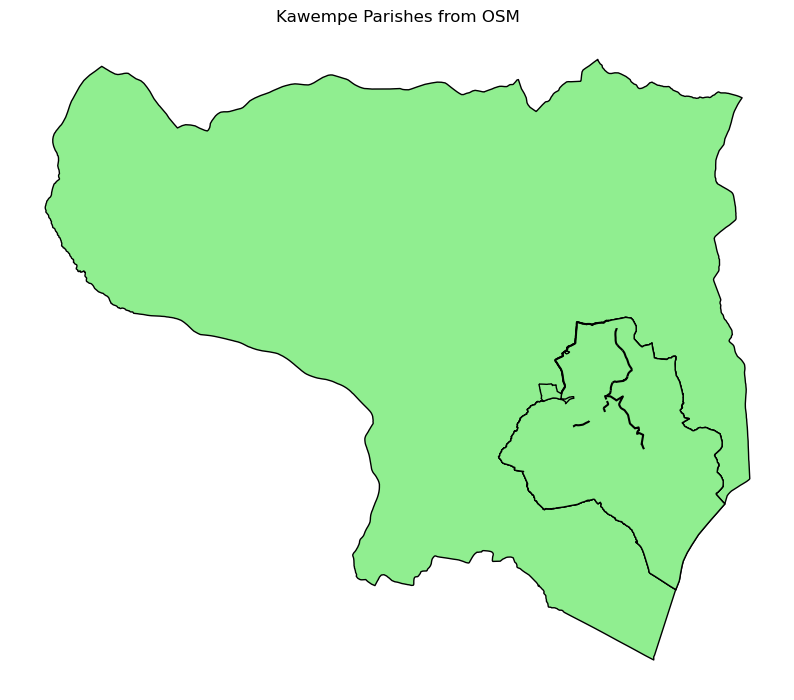

In [5]:
parishes.plot(edgecolor='black', facecolor='lightgreen', figsize=(10, 10))
plt.title('Kawempe Parishes from OSM')
plt.axis('off')
plt.show()

## Step 3: Compute NDVI per Parish

In [6]:
ndvi_path = '../data/raw/Kawempe_NDVI_2023.tif'
stats = zonal_stats(parishes.to_json(), ndvi_path, stats=['mean'], geojson_out=True)
ndvi_gdf = gpd.GeoDataFrame.from_features(stats).set_crs('EPSG:4326')
ndvi_gdf = ndvi_gdf.rename(columns={'mean': 'mean_ndvi'})
ndvi_gdf[['name', 'mean_ndvi']].head()

/opt/anaconda3/envs/urban-risk/lib/python3.10/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,name,mean_ndvi
0,Wakiso,0.001316
1,Kampala,0.064236
2,Central,0.152290
3,Rubaga,0.044666
4,Kawempe,0.122780


## Step 4: Load OSM Infrastructure Layers

In [8]:
buildings = gpd.read_file('../data/raw/kawempe_buildings.geojson').to_crs('EPSG:4326')
roads = gpd.read_file('../data/raw/kawempe_roads.geojson').to_crs('EPSG:4326')
services = gpd.read_file('../data/raw/kawempe_services.geojson').to_crs('EPSG:4326')

## Step 5: Compute Building, Service, and Road Features

In [9]:
# Count buildings per parish
bldg_join = gpd.sjoin(buildings, ndvi_gdf, predicate='within')
building_counts = bldg_join.groupby('name').size().reset_index(name='building_count')

# Count services per parish
svc_join = gpd.sjoin(services, ndvi_gdf, predicate='within')
service_counts = svc_join.groupby('name').size().reset_index(name='service_count')

# Total road length (projected)
roads_proj = roads.to_crs('EPSG:32636')
roads_proj['length_km'] = roads_proj.length / 1000
parishes_proj = ndvi_gdf.to_crs('EPSG:32636')
road_join = gpd.sjoin(roads_proj, parishes_proj, predicate='within')
road_length = road_join.groupby('name')['length_km'].sum().reset_index()

KeyError: 'name'

## Step 6: Merge All Features

In [ ]:
features = ndvi_gdf[['name', 'geometry', 'mean_ndvi']].copy()
features = features.merge(building_counts, on='name', how='left')
features = features.merge(service_counts, on='name', how='left')
features = features.merge(road_length, on='name', how='left')
features[['building_count', 'service_count', 'length_km']] = features[['building_count', 'service_count', 'length_km']].fillna(0)
features.to_file('../data/processed/kawempe_osm_parish_features.geojson', driver='GeoJSON')
features.head()

## Step 7: Visualize Final Risk Features

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
features.plot(column='mean_ndvi', cmap='YlGn', legend=True, ax=axs[0], edgecolor='black')
axs[0].set_title('NDVI')
features.plot(column='building_count', cmap='Oranges', legend=True, ax=axs[1], edgecolor='black')
axs[1].set_title('Buildings')
features.plot(column='service_count', cmap='Blues', legend=True, ax=axs[2], edgecolor='black')
axs[2].set_title('Services')
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()